In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !pip install sentencepiece
# !pip install nlpaug
# !pip install transformers
# import nlpaug.augmenter.word as naw
# from nlpaug.util import Action
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time

from torch.nn.utils import clip_grad_norm_


# !pip install torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CrossEntropyLoss
from transformers import AdamW
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from transformers import XLNetForSequenceClassification, XLNetTokenizer, AdamW, get_linear_schedule_with_warmup

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.2 MB/s eta 0:00:00


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<ipython-input-4-099a244dfef7>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
<ipython-input-4-099a244dfef7>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['attention_mask']),
<ipython-input-4-099a244dfef7>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
<ipython-input-4-099a244dfef7>:25: UserWarning: To copy construct from a tensor, it is recommended to use 

Epoch 1/20 - Train Loss: 2.5277 - Train Accuracy: 0.3844
Epoch 1/20 - Test Loss: 1.0649 - Test Accuracy: 0.7126
Epoch 2/20 - Train Loss: 0.9222 - Train Accuracy: 0.7414
Epoch 2/20 - Test Loss: 0.7383 - Test Accuracy: 0.7738
Epoch 3/20 - Train Loss: 0.6758 - Train Accuracy: 0.7803
Epoch 3/20 - Test Loss: 0.6197 - Test Accuracy: 0.7825
Epoch 4/20 - Train Loss: 0.5725 - Train Accuracy: 0.7975
Epoch 4/20 - Test Loss: 0.5689 - Test Accuracy: 0.7919
Epoch 5/20 - Train Loss: 0.5144 - Train Accuracy: 0.8055
Epoch 5/20 - Test Loss: 0.5618 - Test Accuracy: 0.7876
Epoch 6/20 - Train Loss: 0.4737 - Train Accuracy: 0.8144
Epoch 6/20 - Test Loss: 0.5555 - Test Accuracy: 0.7883
Epoch 7/20 - Train Loss: 0.4393 - Train Accuracy: 0.8241
Epoch 7/20 - Test Loss: 0.5705 - Test Accuracy: 0.7794
Epoch 8/20 - Train Loss: 0.4106 - Train Accuracy: 0.8304
Epoch 8/20 - Test Loss: 0.5715 - Test Accuracy: 0.7771
Epoch 9/20 - Train Loss: 0.3778 - Train Accuracy: 0.8437
Epoch 9/20 - Test Loss: 0.6118 - Test Accuracy:

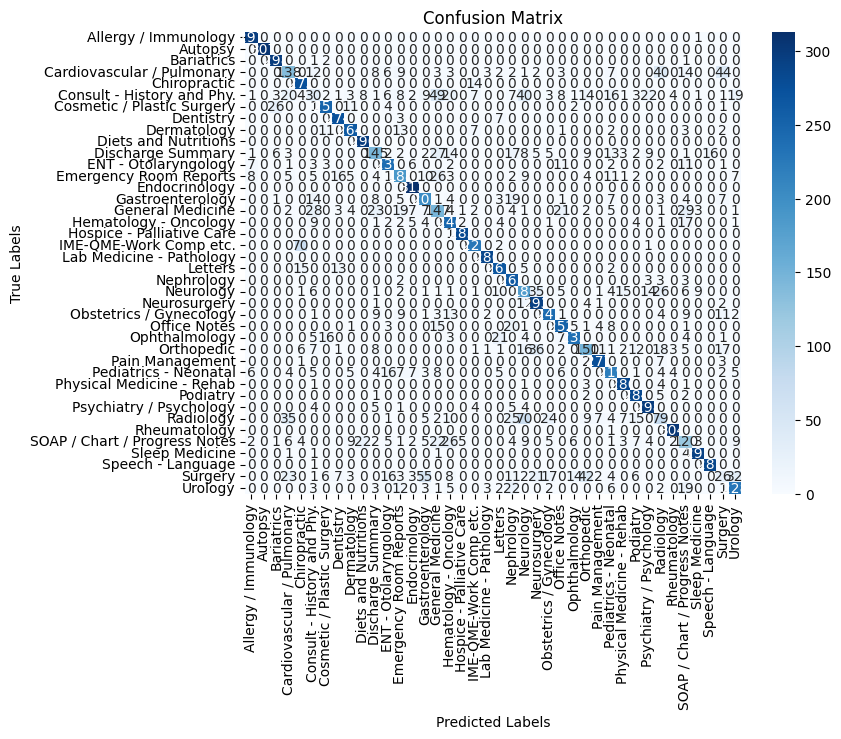

In [4]:
# Step 1: Prepare the data
data = pd.read_csv('/content/drive/MyDrive/NLP Final Project/balanced_data.csv')
data = data.dropna()
X = data['description']
y = data['label']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Fine-tune the XLNet model
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=len(data['label'].unique()))
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')


# Tokenize the input data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512, return_tensors='pt')
# Convert the input data to tensors
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                             torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(y_test))

# Define batch size and create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = CrossEntropyLoss()

# Fine-tune the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 20


train_accuracy_list = []
train_loss_list = []
test_loss_list = []
test_accuracy_list  = []
epoch_list = []


# Learning rate scheduler
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.1 * total_steps) #warmup for the first tex of total steps

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = warmup_steps, num_training_steps = total_steps)

# Initialize variables for early stopping
best_test_accuracy = 0.0
best_epoch = 0
patience = 5
no_improvement_count = 0



tokenizer.save_pretrained('/content/drive/MyDrive/NLP Final Project/XLNET_TOKENIZER')

# Create the directory for model weights if it does not exist
model_directory = '/content/drive/MyDrive/NLP Final Project/XLNET_WEIGHTS'
os.makedirs(model_directory, exist_ok=True)

# Initialize variables for time measurement
total_training_time = 0.0
total_prediction_time = 0.0


for epoch in range(num_epochs):
    epoch_list.append(epoch+1)

    # Start time for training
    start_time_train = time.time()

    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, predicted_labels = torch.max(logits, 1)
        train_correct += (predicted_labels == labels).sum().item()
        train_total += labels.size(0)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()


    train_accuracy = train_correct / train_total
    train_loss = train_loss / len(train_loader)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")

     # End time for training
    end_time_train = time.time()
    epoch_training_time = end_time_train - start_time_train
    total_training_time += epoch_training_time


    # After training loop
    model.eval()

    # Start time for prediction
    start_time_pred = time.time()


    test_loss = 0.0
    test_correct = 0
    test_total = 0



    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, predicted_labels = torch.max(logits, 1)
            test_correct += (predicted_labels == labels).sum().item()
            test_total += labels.size(0)

            test_loss += loss.item()


    test_accuracy = test_correct / test_total
    test_loss = test_loss / len(test_loader)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)
    print(f"Epoch {epoch + 1}/{num_epochs} - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")


    # End time for prediction
    end_time_pred = time.time()
    epoch_prediction_time = end_time_pred - start_time_pred
    total_prediction_time += epoch_prediction_time


    # Check for early stopping condition
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        no_improvement_count = 0
        # Save the model weights and optimizer state dictionary for the best accuracy
        model_path = f'/content/drive/MyDrive/NLP Final Project/XLNET_WEIGHTS/best_model.pt'
        torch.save(model.state_dict(), model_path)
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break



# Calculate precision, recall, and F1 score
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        _, predicted_labels = torch.max(logits, 1)
        all_predictions.extend(predicted_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Print total training and prediction times
print(f"Total Training Time: {total_training_time:.2f} seconds")
print(f"Total Prediction Time: {total_prediction_time:.2f} seconds")

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

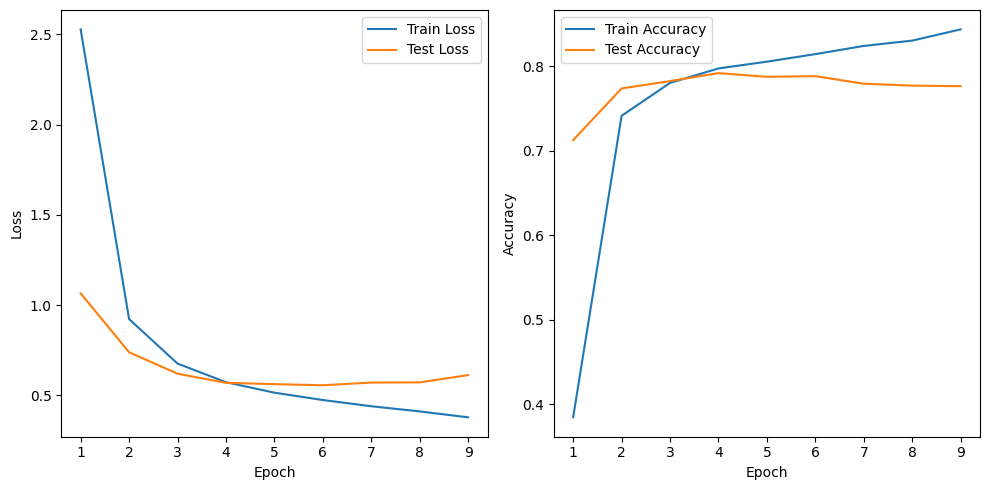

In [5]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_list, train_loss_list, label='Train Loss')
plt.plot(epoch_list, test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_accuracy_list, label='Train Accuracy')
plt.plot(epoch_list, test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

# Save the plots to a specific directory
plots_dir = '/content/drive/MyDrive/NLP Final Project/PLOTS'
os.makedirs(plots_dir, exist_ok=True)
plt.savefig(os.path.join(plots_dir, 'xlnet_loss_and_accuracy_curves.png'))
plt.show()